# How to use the su28 catalog

The catalog is builed using intake for the datasets hosted on the `su28` project. This notebook provide some exaples on how to access the catalog and check the list of datasets and how to read data directly through the catalog. 

If you have questions or suggestions, plase contact the RSE team on Cumulus using the Software Support category.

In [18]:
import intake
import xarray as xr

In [19]:
data_catalog = intake.open_catalog("/g/data/su28/tools/su28_catalog/catalog/su28_catalog.yaml")
list(data_catalog)

['daily_era5']

For example, `daily_era5` includes 17 variables. 

In [20]:
daily_era5 = data_catalog['daily_era5'] # data_catalog.daily_era5 gives the same result
daily_era5

,unique
variable,17
dataset,1
level,2
resolution,1
frequency,1
year,75
name_in_file,17
long_name,17
units,11
path,1257


Other options to explore a dataset are:

* `daily_era5.df` returns a table with the list of files includes and the information available, this can be a very long table.
* `daily_era5.metadata` returns the available metadata.
* `daily_era5.df.columns` returns the columns or *parameters* in the table.
* `daily_era5.search()` allows you to search by a parameter.
* `daily_era5.keys()` returns a list of the keys in that dataset, usually a key will be a combination of more that one parameter in the table.

In [21]:
daily_era5.metadata

{'contact': 'RSE team',
 'created': 'May, 2025',
 'description': 'ERA5 data in daily frequency',
 'keywords': ['era5'],
 'license': None,
 'long_description': 'ERA5 is a climate reanalysis dataset, covering the period 1950 to present. This dataset includes 2d and 3d common variables in daily frequency. The data was also remaped from 0.25 degree to 1 degree. For the original datase check NCI project rt52.',
 'model': ['ERA5'],
 'name': 'daily_era5',
 'nominal_resolution': ['1degree'],
 'catalog_dir': '/g/data/su28/tools/su28_catalog/catalog/'}

To be able to search for specific variables, dates, etc. it importat to understand how that information is saved in the catalog. 

> Note: each dataset will have different paramenters (or columns in the table) depending on their nature.

The first step is to list the column names:

In [22]:
daily_era5.df.columns

Index(['variable', 'dataset', 'level', 'resolution', 'frequency', 'year',
       'name_in_file', 'long_name', 'units', 'path'],
      dtype='object')

Using `daily_era5.unique()` can also help, as it returns not only the column names, also the list of unique elemens in each one.

In [23]:
daily_era5.unique()

variable                [2t, mer, msl, mslhf, msshf, mtpr, mvimd, q, t...
dataset                                                            [era5]
level                                                           [sfc, pl]
resolution                                                         [1deg]
frequency                                                         [daily]
year                    [1950, 1951, 1952, 1953, 1954, 1955, 1956, 195...
name_in_file            [t2m, mer, msl, mslhf, msshf, mtpr, mvimd, q, ...
long_name               [2 metre temperature, Mean evaporation rate, M...
units                   [K, kg m**-2 s**-1, Pa, W m**-2, kg kg**-1, m,...
path                    [/g/data/su28/ERA5/daily/2t/2t_era5_oper_sfc_m...
derived_name_in_file                                                   []
dtype: object

With that information now we can seach for the files that contains temperature at 2 meters by searching for `variable = "2t"`:

In [24]:
daily_era5.search(variable = "2t")


,unique
variable,1
dataset,1
level,1
resolution,1
frequency,1
year,75
name_in_file,1
long_name,1
units,1
path,75


## Reading the data using the catalog

It is also possible to search by more than 1 parameter. Let's search for the data asociated to precipitation for 2018 and read it. Because this is only one file we can use `.to_dask()`.

In [25]:
data_tp = daily_era5.search(variable = "tp", year = 2018).to_dask()
data_tp

<xarray.Dataset> Size: 95MB
Dimensions:    (time: 365, bnds: 2, lon: 360, lat: 180)
Coordinates:
  * time       (time) datetime64[ns] 3kB 2018-01-01T11:00:00 ... 2018-12-31T1...
  * lon        (lon) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat        (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 6kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    tp         (time, lat, lon) float32 95MB dask.array<chunksize=(1, 1, 360), meta=np.ndarray>
Attributes: (12/21)
    CDI:                             Climate Data Interface version 2.4.3 (ht...
    Conventions:                     CF-1.6
    history:                         Wed May 28 16:32:09 2025: cdo mergetime ...
    license:                         Licence to use Copernicus Products: http...
    summary:                         ERA5 is the fifth generation ECMWF atmos...
    title:                           ERA5 single-levels reanalysis total_prec...
    ...                              ...
    intake_esm_attrs:name_in_file:   tp
    intake_esm_attrs:long_name:      Total precipitation
    intake_esm_attrs:units:          m
    intake_esm_attrs:path:           /g/data/su28/ERA5/daily/tp/tp_era5_oper_...
    intake_esm_attrs:_data_format_:  netcdf
    intake_esm_dataset_key:          tp.era5.sfc.1deg.daily

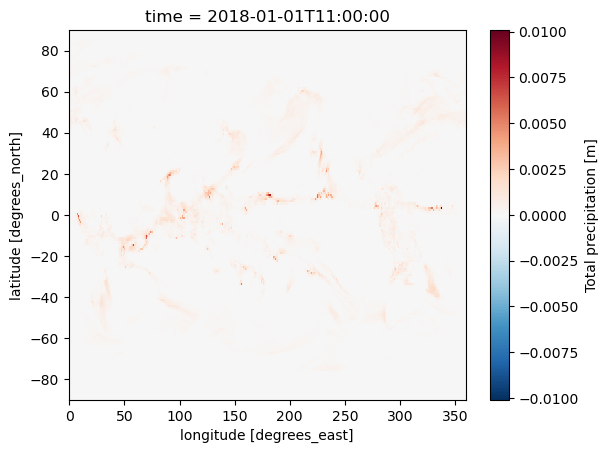

In [26]:
data_tp.tp.isel(time = 0).plot()

## Reading multiple files

To read multiple files we use `.to_dataset_dict()`. This function can handle different file formats:

* NetCDF files using `netcdf4`, `h5netcdf` or `scipy`.
* GRIB files with `cfgrib`.
* Zarr files with `zarr`.

In any case, make sure the require package is installed. 

In [32]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35285 instead
  warnings.warn(


In [28]:
all_tp = daily_era5.search(variable = "tp").to_dataset_dict(combine = 'by_coords', 
                                                            parallel = True, 
                                                            xarray_open_kwargs = {"decode_times": True, "use_cftime": True, "chunks":{'time':100}})
all_tp


--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.dataset.level.resolution.frequency'


{'tp.era5.sfc.1deg.daily': <xarray.Dataset> Size: 7GB
 Dimensions:    (time: 27394, lat: 180, lon: 360, bnds: 2)
 Coordinates:
   * time       (time) object 219kB 1950-01-01 11:00:00 ... 2024-12-31 11:00:00
     time_bnds  (time, bnds) object 438kB dask.array<chunksize=(100, 2), meta=np.ndarray>
   * lon        (lon) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
   * lat        (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
 Dimensions without coordinates: bnds
 Data variables:
     tp         (time, lat, lon) float32 7GB dask.array<chunksize=(100, 1, 360), meta=np.ndarray>
 Attributes: (12/17)
     CDI:                             Climate Data Interface version 2.4.3 (ht...
     Conventions:                     CF-1.6
     license:                         Licence to use Copernicus Products: http...
     summary:                         ERA5 is the fifth generation ECMWF atmos...
     frequency:                       day
     CDO:                       

In [31]:
client.close()
cluster.close()

---
This tutorial was inspired by the "Introduction to NCI’s Data Catalogue and Indexing Schemes" workshop materials by NCI and [Introduction to the ACCESS-NRI Intake catalog](https://github.com/ACCESS-NRI/workshop-training-2023/blob/main/intake/Intake_tutorial_p1.ipynb) by ACCESS-NRI.